# Entry 25 notebook - Setting thresholds - Horse colic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve

In [2]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

## Make dataset and fit model

In [3]:
target = 'outcome'
names = ['surgery', 'age', 'hosp_num', 'rectal_temp', 'pulse', 'respiratory_rate', 'extremity_temp',
                  'peripheral_pulse', 'mucous_membranes', 'cap_refill_time', 'pain', 'peristalsis',
                  'ab_distension', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
                  'rectal_exam', 'abdomen', 'packed_cell_vol', 'total_protein', 'abdominocentesis_app',
                  'abdomcentesis_total_protein', 'outcome', 'surgical_lesion',
                   'lesion_type', 'lesion2', 'lesion3', 'cp_data']
# cat_feats = ['surgery', 'age', 'mucous_membranes', 'cap_refill_time', 'pain', 'peristalsis',
#              'ab_distension', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam',
#              'abdomen', 'abdominocentesis_app', 'surgical_lesion', 'lesion_type', 'cp_data']
num_feats = ['rectal_temp', 'pulse', 'respiratory_rate', 'extremity_temp', 'peripheral_pulse',
             'nasogastric_reflux_ph', 'packed_cell_vol', 'total_protein', 'abdomcentesis_total_protein']


In [4]:
raw_df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.data",
            names=names, sep='\s', engine='python', na_values='?')
raw_df.drop(['lesion2','lesion3', 'hosp_num'], axis=1, inplace=True)

In [5]:
test_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.test",
            names=names, sep='\s', engine='python', na_values='?')
test_data.drop(['lesion2','lesion3', 'hosp_num'], axis=1, inplace=True)

In [6]:
raw_df.dropna(subset=['outcome'], inplace=True)
y_train = raw_df['outcome']
X_train = raw_df[num_feats]
y_test = test_data['outcome']
X_test = test_data[num_feats]

In [7]:
y_train.value_counts()

1.0    178
2.0     77
3.0     44
Name: outcome, dtype: int64

I looked at the meaning of the outcome values in the documentation:

- what eventually happened to the horse?
- possible values:
       - 1 = lived
       - 2 = died
       - 3 = was euthanized

Based on this, it seems there are really 2 outcomes, survived yes/no. As such, I'm going to combine categories 2 and 3.

In [8]:
y_train = np.where(y_train>2, 2, y_train)
y_test = np.where(y_test>2, 2, y_test)

In [9]:
pd.DataFrame(y_test)[0].value_counts()

1.0    47
2.0    20
Name: 0, dtype: int64

In [10]:
pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [11]:
cross_validate(pipe, X_train, y_train, cv=10, scoring=['precision', 'average_precision', 'recall',
                                                       'f1', 'neg_log_loss', 'neg_brier_score'])

{'fit_time': array([0.00762606, 0.00840592, 0.00617504, 0.00469589, 0.00412416,
        0.00403571, 0.00474286, 0.00601315, 0.00406098, 0.00400996]),
 'score_time': array([0.00627398, 0.00584412, 0.00669312, 0.00485897, 0.00481486,
        0.00550318, 0.00447893, 0.00527573, 0.004807  , 0.00444007]),
 'test_precision': array([0.73684211, 0.8125    , 0.80952381, 0.66666667, 0.76190476,
        0.69565217, 0.72727273, 0.76470588, 0.75      , 0.76470588]),
 'test_average_precision': array([0.42289173, 0.43756319, 0.46262245, 0.46779448, 0.49951242,
        0.46649085, 0.44512633, 0.53770185, 0.4746786 , 0.53402921]),
 'test_recall': array([0.82352941, 0.72222222, 0.94444444, 0.88888889, 0.88888889,
        0.88888889, 0.88888889, 0.72222222, 0.83333333, 0.76470588]),
 'test_f1': array([0.77777778, 0.76470588, 0.87179487, 0.76190476, 0.82051282,
        0.7804878 , 0.8       , 0.74285714, 0.78947368, 0.76470588]),
 'test_neg_log_loss': array([-0.51478669, -0.4851278 , -0.44563539, -0.52350

### Precision vs Recall

So basically, this really long error message means there is a `nan` value in the test data - one of the target values is missing. Why anyone would do such a thing is beyond me.

In [12]:
y_scores = cross_val_predict(pipe, X_train, y_train, cv=10, method='decision_function')

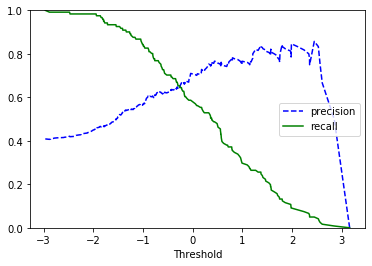

In [13]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores, pos_label=2)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

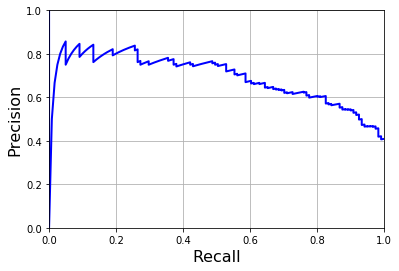

In [14]:
plot_precision_vs_recall(precisions, recalls)

### ROC Curve and ROC AUC

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plt_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

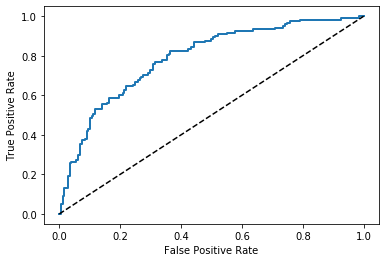

In [17]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores, pos_label=2)
plt_roc_curve(fpr, tpr)

In [20]:
roc_auc_score(y_train, y_scores)

0.7886526139845854